# Weather Forecast
In this notebook, we will develop some machine learning models in order to forecast the weather. More specifically the purpose of the model will be to predict if there will be any rain tomorrow. We will use dataset Australia, Rain Tomorrow that is available in Kaggle. First we import all the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
from matplotlib import pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## EDA
First we perform Exploratory Data Analysis in order to make ourselves familiar with the dataset.

In [2]:
df_raw = pd.read_csv("australia_rain_tomorrow_raw.csv")

In [3]:
df_raw.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,01/12/2008,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,02/12/2008,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,03/12/2008,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,04/12/2008,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,05/12/2008,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


The last column - Rain Tomorrow will be the label for this dataset. The rest 23 columns will be the features.

In [4]:
df_raw.shape

(142193, 24)

In [5]:
list(df_raw.columns)

['Date',
 'Location',
 'MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustDir',
 'WindGustSpeed',
 'WindDir9am',
 'WindDir3pm',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday',
 'RISK_MM',
 'RainTomorrow']

First of all, we can assume that date does not really affects the weather and it was added to the dataset for recording reasons.

In [6]:
df_features = df_raw.drop(columns=["Date","RainTomorrow"], axis=1)
df_labels = df_raw[["RainTomorrow"]]

In [7]:
df_features.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000,142193.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235,2.360682
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594,8.477969
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,0.000000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,0.800000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,371.000000


Then we examine with features are categorical and which features are numerical.

In [8]:
categorical_features = list(df_features.select_dtypes(exclude="number").columns)
categorical_features

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

In [9]:
numerical_features = list(df_features.select_dtypes(include="number").columns)
numerical_features

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RISK_MM']

In [10]:
df_labels.RainTomorrow.unique()

array(['No', 'Yes'], dtype=object)

Our labels get Yes or No Values so we have map those to 1 and 0 respectively

In [11]:
df_labels = df_labels.RainTomorrow.map(lambda x: 0 if x=="No" else 1)

Next we will examine the correlation matrix of the numerical features. When the correlation between two features is high, the change in on of them causes similar change to the other.

C:\Users\User\AppData\Local\Temp\ipykernel_18472\2482773115.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_features.corr()


<Axes: >

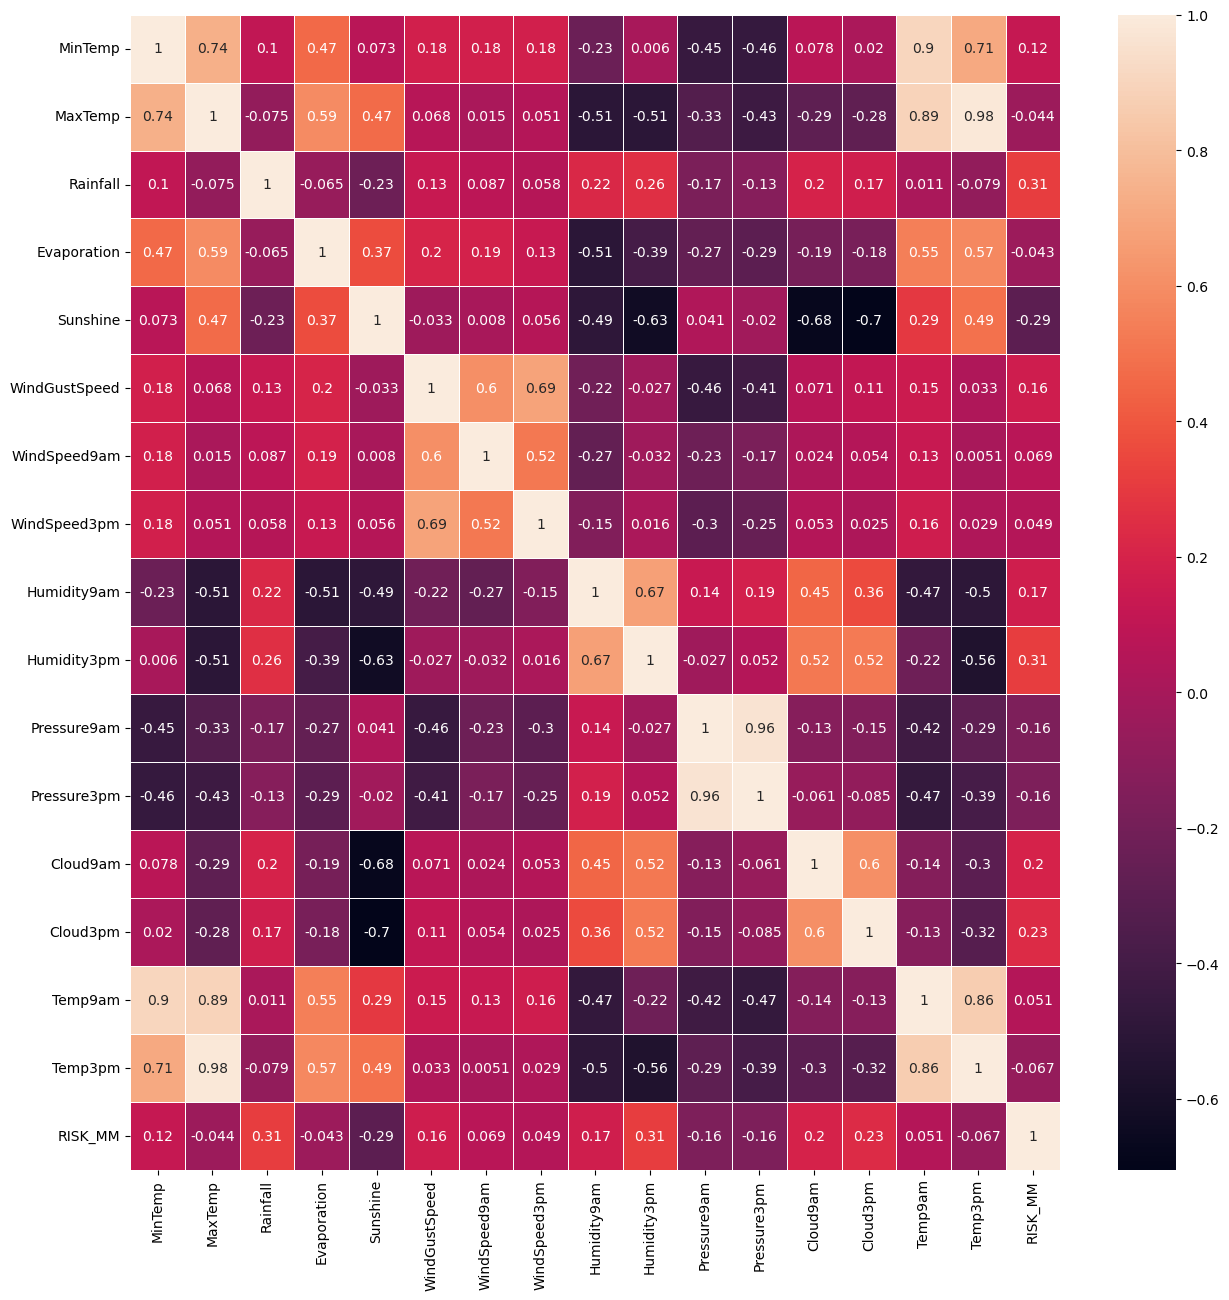

In [12]:
corr_matrix = df_features.corr()
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sn.heatmap(corr_matrix, annot=True,linewidths=.5, ax=ax)

## Preprocessing

Checking the correlation matrix, we can see that some features have high correlation. Those features have the same scale and we can fuse them. For example MinTemp, MaxTemp, Temp9am, Temp3pm have correlation bigger than 0.71, and the intuition is that in a rainy day the temperature during the whole day is going to be low. Same happens with WindGustSpeed, WindSpeed9am, WindSpeed3pm , that in a rainy day we expect that there will be some wind. Moreover we expect that there will be some clouds during the day so we will also fuse Cloud9am and Cloud3pm. Humidity will be high during the day so we can fuse the features Humidity9am, Humidity3pm as well as pressure, which means that we can fuse the features Pressure9am, Pressure3pm.

In [13]:
df_fused = df_features.copy(deep=True)

C:\Users\User\AppData\Local\Temp\ipykernel_18472\4214877483.py:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix_fused = df_fused.corr()


<Axes: >

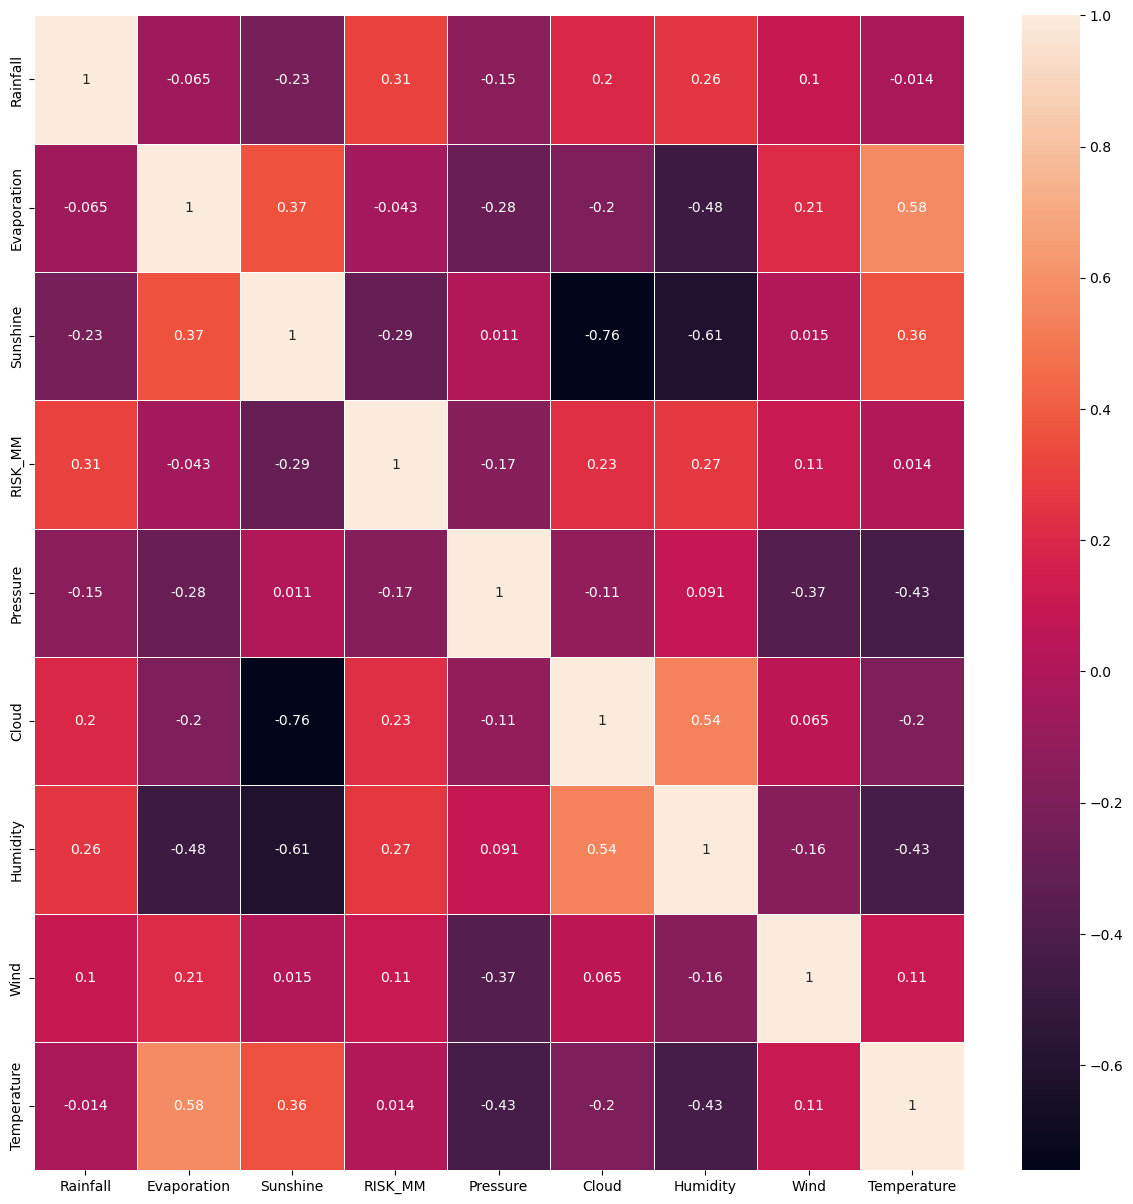

In [14]:
df_fused["Pressure"] = df_fused.loc[:,["Pressure9am", "Pressure3pm"]].mean(axis=1)
df_fused.drop(columns=["Pressure9am", "Pressure3pm"], inplace=True)
df_fused["Cloud"] = df_fused.loc[:,["Cloud9am", "Cloud3pm"]].mean(axis=1)
df_fused.drop(columns=["Cloud9am", "Cloud3pm"], inplace=True)
df_fused["Humidity"] = df_fused.loc[:,["Humidity9am", "Humidity3pm"]].mean(axis=1)
df_fused.drop(columns=["Humidity9am", "Humidity3pm"], inplace=True)
df_fused["Wind"] = df_fused.loc[:,["WindGustSpeed","WindSpeed9am", "WindSpeed3pm"]].mean(axis=1)
df_fused.drop(columns=["WindGustSpeed", "WindSpeed9am","WindSpeed3pm"], inplace=True)
df_fused["Temperature"] = df_fused.loc[:,["MinTemp","MaxTemp", "Temp9am","Temp3pm"]].mean(axis=1)
df_fused.drop(columns=["MinTemp","MaxTemp", "Temp9am","Temp3pm"], inplace=True)

corr_matrix_fused = df_fused.corr()
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sn.heatmap(corr_matrix_fused, annot=True,linewidths=.5, ax=ax)

By computing again the correlation matrix, we can see that we have much more clearer relations between features. There again some high correlation features like Evaporation - Temperature and Cloud - Humidity which are expected, however it is difficult to fuse them considering that they are measured in different scales. Next we will examine if there are any missing values in our features.

Text(0, 0.5, 'Sample Number')

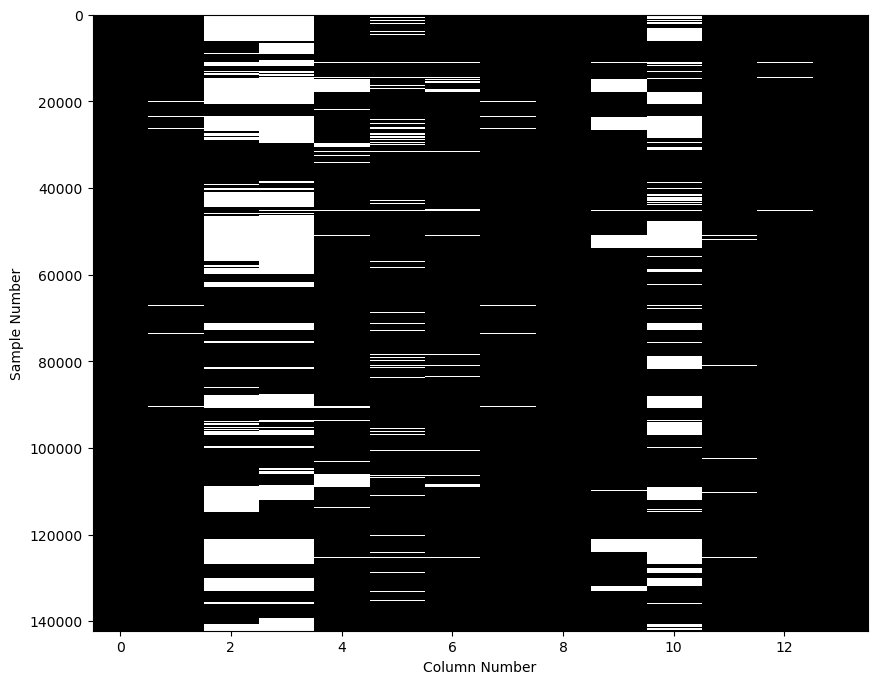

In [15]:
plt.figure(figsize=(10,8))
plt.imshow(df_fused.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number")

<Axes: title={'center': 'Percentage of missing values per feature'}, ylabel='Ratio of percentage per feature'>

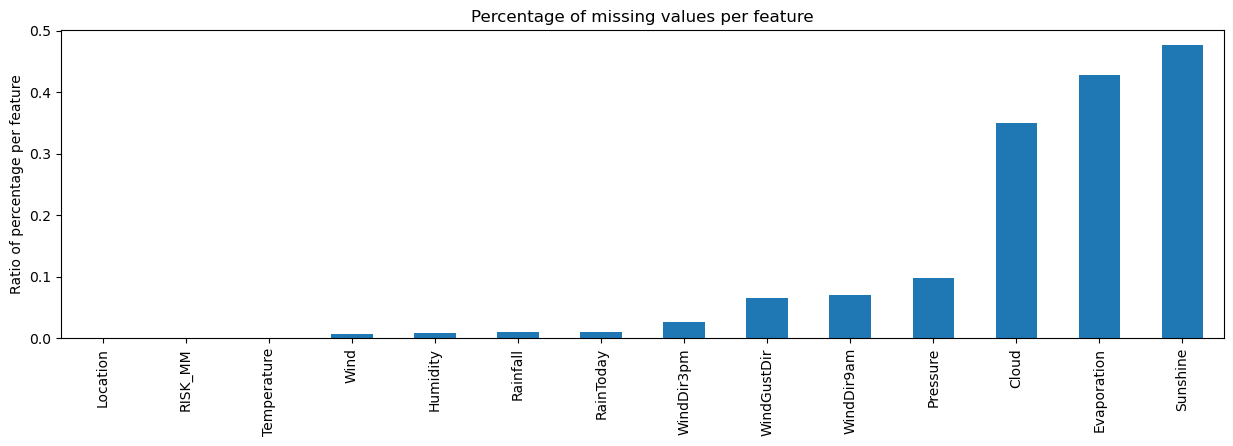

In [16]:
df_fused.isna().mean().sort_values().plot(kind="bar", figsize=(15,4), 
                                          title="Percentage of missing values per feature", 
                                          ylabel="Ratio of percentage per feature")

We can see that some features like Cloud, Evaporation and Sunshine have a high percentage of missing values above 35%. For that reason we will ignore those features and more specifically we will ignore completely the features that have missing values above 15%. We will also drop the rows that have missing values for the categorical features considering that their percentage is relatively low.

In [17]:
df_clear_missing_per = df_fused.dropna(thresh=df_fused.shape[0] * 0.85, axis=1)
# .dropna(subset=categorical_features, axis=0)

<Axes: title={'center': 'Percentage of missing values per feature'}, ylabel='Ratio of percentage per feature'>

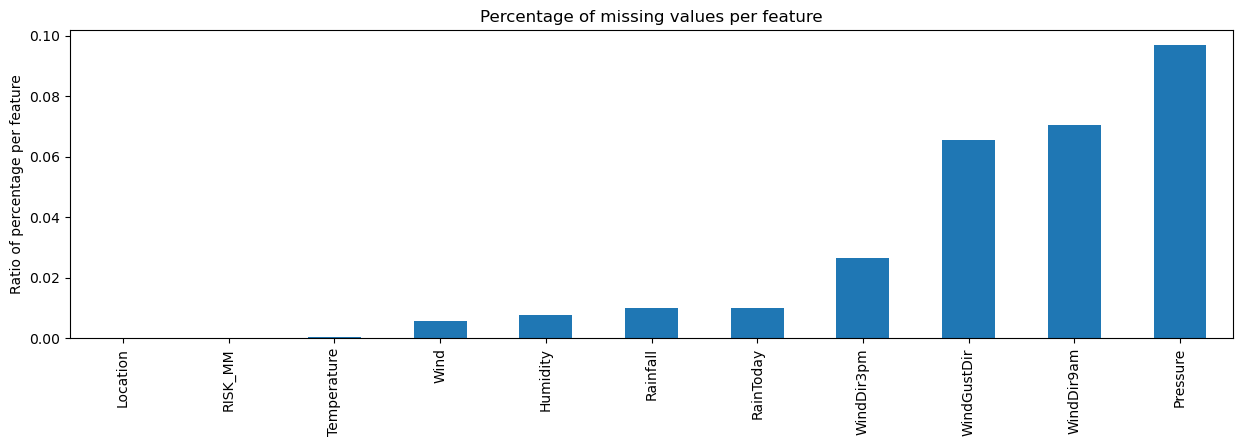

In [18]:
df_clear_missing_per.isna().mean().sort_values().plot(kind="bar", figsize=(15,4), 
                                          title="Percentage of missing values per feature", 
                                          ylabel="Ratio of percentage per feature")

Next we define a preprocessing pipeline. First we will replace the missing values of the numerical features with their median values and will apply Standard Scaler to the numerical features. We will apply OneHotEncoder for the categorical features in order to transform them into vector representation with 1 and 0.

In [19]:
numerical_features = list(df_clear_missing_per.select_dtypes(include="number").columns)
print(numerical_features)

numerical_imputer = SimpleImputer(strategy="median")
numerical_scaler = StandardScaler()

numerical_transformer = Pipeline(
    steps=[("imputer", numerical_imputer), ("scaler", numerical_scaler)]
)

['Rainfall', 'RISK_MM', 'Pressure', 'Humidity', 'Wind', 'Temperature']


In [20]:
categorical_features = list(df_clear_missing_per.select_dtypes(exclude="number").columns)
print(categorical_features)

categorical_scaler = OneHotEncoder(handle_unknown="ignore")
categorical_imputer = SimpleImputer(strategy="most_frequent")

categorical_transformer = Pipeline(
    steps=[('imputer', categorical_imputer), ('scaler', categorical_scaler)]
) 

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


In [21]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [22]:
cleared_data = preprocessor.fit_transform(df_clear_missing_per).toarray()

After we have cleared and preprocess our dataset we will split our dataset into train and test data. We will use train data to train our machine learning models, and test data in order to evaluate them.

In [23]:
X_train, X_test, y_train, y_test = train_test_split( cleared_data, df_labels, test_size=0.30, random_state=42)

## Model Training and Evaluation
We will define machine learning models using scikit-learn. The models we will examine are:
<ol>
  <li>Naive Bayes</li>
  <li>k-Nearest Neighbors</li>
  <li>Logistic Regression</li>
  <li>Decision Trees</li>
  <li>Random Forest</li>
</ol> 

In order to optimize our solution we will use 10-fold Cross Validation and Grid Search. We will define a search space for the hyperparameters of each model. Then we will train our model and examine its classification report.

In [24]:
gnb_grid = GridSearchCV(GaussianNB(), param_grid = {'var_smoothing': np.logspace(0,-16, num=20)}, cv=10, verbose=0)
gnb_pred = gnb_grid.fit(X_train, y_train).predict(X_test)
print("Classification Report for 10-folds Naive Bayes Classifier")
print(classification_report(y_test, gnb_pred))

Classification Report for 10-folds Naive Bayes Classifier
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     33133
           1       0.68      0.78      0.72      9525

    accuracy                           0.87     42658
   macro avg       0.80      0.83      0.82     42658
weighted avg       0.88      0.87      0.87     42658



In [25]:
knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid = { 'n_neighbors' : range(1,11,2), 'metric': ['euclidean','manhattan']}, 
                        cv=10, verbose=0)
knn_pred = knn_grid.fit(X_train, y_train).predict(X_test)
print("Classification Report for 10-folds k-Nearest Neighbor Classifier")
print(classification_report(y_test, knn_pred))

Classification Report for 10-folds k-Nearest Neighbor Classifier
              precision    recall  f1-score   support

           0       0.88      0.98      0.93     33133
           1       0.89      0.54      0.67      9525

    accuracy                           0.88     42658
   macro avg       0.88      0.76      0.80     42658
weighted avg       0.88      0.88      0.87     42658



In [26]:
lr_grid = GridSearchCV(LogisticRegression(), param_grid = {'penalty': ["l1", "l2"], "C": np.logspace(0, 4, num=10)}, 
                       cv=10, verbose=0)
lr_pred = lr_grid.fit(X_train, y_train).predict(X_test)
print("Classification Report for 10-folds Logistic Regression Classifier")
print(classification_report(y_test, lr_pred))

Classification Report for 10-folds Logistic Regression Classifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33133
           1       1.00      1.00      1.00      9525

    accuracy                           1.00     42658
   macro avg       1.00      1.00      1.00     42658
weighted avg       1.00      1.00      1.00     42658



In [27]:
dt_grid = GridSearchCV(DecisionTreeClassifier(), param_grid = {'criterion': ["gini", "entropy"], 
                                                               'max_depth': range(2,12,3)}, cv=10, verbose=0)
dt_pred = dt_grid.fit(X_train, y_train).predict(X_test)
print("Classification Report for 10-folds Decision Classifier")
print(classification_report(y_test, dt_pred))

Classification Report for 10-folds Decision Classifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33133
           1       1.00      1.00      1.00      9525

    accuracy                           1.00     42658
   macro avg       1.00      1.00      1.00     42658
weighted avg       1.00      1.00      1.00     42658



In [28]:
rf_grid = GridSearchCV(RandomForestClassifier(), param_grid = {'criterion': ["gini", "entropy"], 
                                                               'n_estimators': [50,100,200],
                                                               'max_depth': range(2,12,3)}, cv=10, verbose=0)
rf_pred = rf_grid.fit(X_train, y_train).predict(X_test)
print("Classification Report for 10-folds Random Forest Classifier")
print(classification_report(y_test, rf_pred))

Classification Report for 10-folds Random Forest Classifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33133
           1       1.00      1.00      1.00      9525

    accuracy                           1.00     42658
   macro avg       1.00      1.00      1.00     42658
weighted avg       1.00      1.00      1.00     42658



## Conclusion
According to the classification reports of the models we trained, we have achieved good results using 10-fold Cross Validation and hyperparameter optimization. Specifically we achieved perfect score for all the metrics for the Logistic Regression, the Decision Tree Classifier and the Random Forest Classisier. Finally we check the best hyperparameters for the models that we achieved the best results.

In [37]:
print("The best parameters for the Logistic Regression Classifier are :")
print(lr_grid.best_params_)
print("The best parameters for the Decision Tree Classifier are :")
print(dt_grid.best_params_)
print("The best parameters for the Random Forest Classifier are :")
print(rf_grid.best_params_)

The best parameters for the Logistic Regression Classifier are :
{'C': 3593.813663804626, 'penalty': 'l2'}
The best parameters for the Decision Tree Classifier are :
{'criterion': 'gini', 'max_depth': 2}
The best parameters for the Random Forest Classifier are :
{'criterion': 'gini', 'max_depth': 8, 'n_estimators': 100}


## References
<ol>
  <li>R. O. Duda, P.E. Hart and D.G. Stork, Pattern Classification, Wiley, 2001</li>
  <li>C. M. Bishop, Pattern Recognition and Machine Learning, Springer, 2006</li>
</ol> 